<h1>Feature engineering and basic filtering</h1>

In this notebook we finalise this project by generating a "feature space" that summarises the immunological landscape of the peritoneal effluent from the patients in this study. The `feature_selection` module, which actually contains many tools beyond the umbrella term 'feature selection', simplifies drawing population summary statistics together to model against meta data contained within `Subject`'s.

In [ ]:
from cytopy.data.setup import global_init
from cytopy.data.project import Project
from cytopy.flow import feature_selection
global_init("Peritonitis")

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import re

sns.set(style="white", font_scale=1.3)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [4]:
project = Project.objects(project_id="Immunofingerprints").get()
tcells = project.get_experiment("Corrected drain fluid T cells")
leukocytes = project.get_experiment("Corrected drain fluid Leukocytes")

<h2>Creating a feature space</h2>

The first step is to generate a DataFrame of population statistics for each individual in the project. We can generate these statistics for each of the different methods we used to identify our cell populations and then compare the outcome from each, increasing the confidence of our findings as they are drawn from both biased and unbiased classification of cells. 

<h3>Generate merged populations</h3>

For our clustering analysis we generated subsets of CD4$^{+}$ and CD8$^{+}$, therefore we want to create additional populations that are a merger of these subsets. The `merge_populations` method of `Experiment` can be used to generate a new population for each `FileGroup` that is a merger of many populations within each `FileGroup`. 

We provide a dictionary where the key is the name of the new population we want to generate and the values are a list of the names of populations we want to merge to form this new population. If one or more populations are missing in the `FileGroup` then the merger will be made using the populations that are available. There must be at least two populations to make a merger, so if only one or no populations are present, an warning will be given and no merger will occur.

This action does not remove any populations, so those CD4$^{+}$ subsets will still be accessible, it simply generates a new population for each `FileGroup` in the `Experiment`.

In [5]:
# Merge Phenograph CD4 populations
tcells.merge_populations({"Phenograph_CD4+ T cells": [f"Phenograph_CD4+ T cells ({i + 1})" 
                                                      for i in range (5)]})

<ipython-input-5-f705a2be9fad>:1: UserWarning: Failed to merge populations for Training Data: Populations for merging should share the same parent
  tcells.merge_populations({"Phenograph_CD4+ T cells": [f"Phenograph_CD4+ T cells ({i + 1})"


We get a warning that there was a failure to create the merged population for the `FileGroup` named "Training Data". This is okay, that `FileGroup` exists purely for training our XGBoost model and can be ignored.

In [6]:
tcells.merge_populations({"Phenograph_CD8+ T cells": [f"Phenograph_CD8+ T cells ({i + 1})" 
                                                      for i in range (3)]})

<ipython-input-6-761895ffa6ef>:1: UserWarning: Failed to merge populations for Corrected_165-09: Provide two or more populations for merging
  tcells.merge_populations({"Phenograph_CD8+ T cells": [f"Phenograph_CD8+ T cells ({i + 1})"
<ipython-input-6-761895ffa6ef>:1: UserWarning: Failed to merge populations for Corrected_209-03: Provide two or more populations for merging
  tcells.merge_populations({"Phenograph_CD8+ T cells": [f"Phenograph_CD8+ T cells ({i + 1})"
<ipython-input-6-761895ffa6ef>:1: UserWarning: Failed to merge populations for Corrected_323-01: Provide two or more populations for merging
  tcells.merge_populations({"Phenograph_CD8+ T cells": [f"Phenograph_CD8+ T cells ({i + 1})"
<ipython-input-6-761895ffa6ef>:1: UserWarning: Failed to merge populations for Training Data: Populations for merging should share the same parent
  tcells.merge_populations({"Phenograph_CD8+ T cells": [f"Phenograph_CD8+ T cells ({i + 1})"


We see a few errors above with the merger of populations in a few `FileGroup`'s. The warning messages suggest that either no CD8$^{+}$ populations are present (which should not be the case) or that only one is encountered and therefore merging is not possible. In this case we want to simply rename the population to "Phenograph_CD8+ T cells".

In [7]:
f = tcells.get_sample("Corrected_165-09")
f.print_population_tree()

root
├── XGB_Unclassified
├── XGB_Vd2+ GDTs
├── XGB_MAIT cells
├── XGB_CD8+ T cells
├── XGB_CD4+ T cells
├── FlowSOM_CD4+ T cells (1)
├── FlowSOM_CD4+ T cells (2)
├── FlowSOM_CD4+ T cells (3)
├── FlowSOM_CD8+ T cells (1)
├── FlowSOM_CD8+ T cells (2)
├── FlowSOM_MAIT cells
├── FlowSOM_Vd2+ GDTs
├── Phenograph_CD4+ T cells (4)
├── Phenograph_CD4+ T cells (5)
├── Phenograph_CD8+ T cells (2)
├── Phenograph_Vd2+ GDTs
└── Phenograph_CD4+ T cells


Above we see that this is indeed the case for `FileGroup` "Corrected_165-09", therefore I can rename the population:

In [8]:
f.get_population("Phenograph_CD8+ T cells (2)").population_name = "Phenograph_CD8+ T cells"
f.save()

Let us check the others:

In [9]:
f = tcells.get_sample("Corrected_209-03")
f.print_population_tree()

root
├── XGB_Unclassified
├── XGB_Vd2+ GDTs
├── XGB_MAIT cells
├── XGB_CD8+ T cells
├── XGB_CD4+ T cells
├── FlowSOM_CD4+ T cells (1)
├── FlowSOM_CD4+ T cells (2)
├── FlowSOM_CD4+ T cells (3)
├── FlowSOM_CD4+ T cells (4)
├── FlowSOM_CD8+ T cells (1)
├── FlowSOM_Vd2+ GDTs
├── Phenograph_CD4+ T cells (1)
├── Phenograph_CD4+ T cells (2)
├── Phenograph_CD4+ T cells (3)
├── Phenograph_CD4+ T cells (4)
├── Phenograph_CD4+ T cells (5)
├── Phenograph_CD8+ T cells (1)
├── Phenograph_Vd2+ GDTs
└── Phenograph_CD4+ T cells


In [10]:
f.get_population("Phenograph_CD8+ T cells (1)").population_name = "Phenograph_CD8+ T cells"
f.save()

In [11]:
f = tcells.get_sample("Corrected_323-01")
f.print_population_tree()

root
├── XGB_Unclassified
├── XGB_Vd2+ GDTs
├── XGB_MAIT cells
├── XGB_CD8+ T cells
├── XGB_CD4+ T cells
├── FlowSOM_CD4+ T cells (1)
├── FlowSOM_CD4+ T cells (2)
├── FlowSOM_CD4+ T cells (3)
├── FlowSOM_CD4+ T cells (4)
├── FlowSOM_CD4- CD8- T cells
├── FlowSOM_CD8+ T cells (2)
├── FlowSOM_MAIT cells
├── FlowSOM_Vd2+ GDTs
├── Phenograph_CD4+ T cells (1)
├── Phenograph_CD4+ T cells (3)
├── Phenograph_CD4+ T cells (4)
├── Phenograph_CD4+ T cells (5)
├── Phenograph_CD4- CD8- T cells
├── Phenograph_CD8+ T cells (2)
├── Phenograph_MAIT cells
├── Phenograph_Vd2+ GDTs
└── Phenograph_CD4+ T cells


In [12]:
f.get_population("Phenograph_CD8+ T cells (2)").population_name = "Phenograph_CD8+ T cells"
f.save()

With that corrected for, let's do the same for FlowSOM generated populations:

In [13]:
tcells.merge_populations({"FlowSOM_CD4+ T cells": [f"FlowSOM_CD4+ T cells ({i + 1})" for i in range (5)]})

<ipython-input-13-6f4460ea14f2>:1: UserWarning: Failed to merge populations for Training Data: Populations for merging should share the same parent
  tcells.merge_populations({"FlowSOM_CD4+ T cells": [f"FlowSOM_CD4+ T cells ({i + 1})" for i in range (5)]})


In [14]:
tcells.merge_populations({"FlowSOM_CD8+ T cells": [f"FlowSOM_CD8+ T cells ({i + 1})" for i in range (2)]})

<ipython-input-14-7ffe4024c749>:1: UserWarning: Failed to merge populations for Corrected_209-03: Provide two or more populations for merging
  tcells.merge_populations({"FlowSOM_CD8+ T cells": [f"FlowSOM_CD8+ T cells ({i + 1})" for i in range (2)]})
<ipython-input-14-7ffe4024c749>:1: UserWarning: Failed to merge populations for Corrected_322-01: Provide two or more populations for merging
  tcells.merge_populations({"FlowSOM_CD8+ T cells": [f"FlowSOM_CD8+ T cells ({i + 1})" for i in range (2)]})
<ipython-input-14-7ffe4024c749>:1: UserWarning: Failed to merge populations for Corrected_323-01: Provide two or more populations for merging
  tcells.merge_populations({"FlowSOM_CD8+ T cells": [f"FlowSOM_CD8+ T cells ({i + 1})" for i in range (2)]})
<ipython-input-14-7ffe4024c749>:1: UserWarning: Failed to merge populations for Training Data: Populations for merging should share the same parent
  tcells.merge_populations({"FlowSOM_CD8+ T cells": [f"FlowSOM_CD8+ T cells ({i + 1})" for i in ran

In [15]:
f = tcells.get_sample("Corrected_209-03")
f.print_population_tree()

root
├── XGB_Unclassified
├── XGB_Vd2+ GDTs
├── XGB_MAIT cells
├── XGB_CD8+ T cells
├── XGB_CD4+ T cells
├── FlowSOM_CD4+ T cells (1)
├── FlowSOM_CD4+ T cells (2)
├── FlowSOM_CD4+ T cells (3)
├── FlowSOM_CD4+ T cells (4)
├── FlowSOM_CD8+ T cells (1)
├── FlowSOM_Vd2+ GDTs
├── Phenograph_CD4+ T cells (1)
├── Phenograph_CD4+ T cells (2)
├── Phenograph_CD4+ T cells (3)
├── Phenograph_CD4+ T cells (4)
├── Phenograph_CD4+ T cells (5)
├── Phenograph_CD8+ T cells (1)
├── Phenograph_Vd2+ GDTs
├── Phenograph_CD4+ T cells
└── FlowSOM_CD4+ T cells


In [16]:
f.get_population("FlowSOM_CD8+ T cells (1)").population_name = "FlowSOM_CD8+ T cells"
f.save()

In [17]:
f = tcells.get_sample("Corrected_322-01")
f.print_population_tree()

root
├── XGB_Unclassified
├── XGB_Vd2+ GDTs
├── XGB_MAIT cells
├── XGB_CD8+ T cells
├── XGB_CD4+ T cells
├── FlowSOM_CD4+ T cells (1)
├── FlowSOM_CD4+ T cells (2)
├── FlowSOM_CD4+ T cells (3)
├── FlowSOM_CD4+ T cells (4)
├── FlowSOM_CD8+ T cells (2)
├── FlowSOM_MAIT cells
├── FlowSOM_Vd2+ GDTs
├── Phenograph_CD4+ T cells (2)
├── Phenograph_CD4+ T cells (3)
├── Phenograph_CD4+ T cells (4)
├── Phenograph_CD4+ T cells (5)
├── Phenograph_CD4- CD8- T cells
├── Phenograph_CD8+ T cells (2)
├── Phenograph_CD8+ T cells (3)
├── Phenograph_MAIT cells
├── Phenograph_Vd2+ GDTs
├── Phenograph_CD4+ T cells
├── Phenograph_CD8+ T cells
└── FlowSOM_CD4+ T cells


In [18]:
f.get_population("FlowSOM_CD8+ T cells (2)").population_name = "FlowSOM_CD8+ T cells"
f.save()

In [19]:
f = tcells.get_sample("Corrected_323-01")
f.print_population_tree()

root
├── XGB_Unclassified
├── XGB_Vd2+ GDTs
├── XGB_MAIT cells
├── XGB_CD8+ T cells
├── XGB_CD4+ T cells
├── FlowSOM_CD4+ T cells (1)
├── FlowSOM_CD4+ T cells (2)
├── FlowSOM_CD4+ T cells (3)
├── FlowSOM_CD4+ T cells (4)
├── FlowSOM_CD4- CD8- T cells
├── FlowSOM_CD8+ T cells (2)
├── FlowSOM_MAIT cells
├── FlowSOM_Vd2+ GDTs
├── Phenograph_CD4+ T cells (1)
├── Phenograph_CD4+ T cells (3)
├── Phenograph_CD4+ T cells (4)
├── Phenograph_CD4+ T cells (5)
├── Phenograph_CD4- CD8- T cells
├── Phenograph_CD8+ T cells (2)
├── Phenograph_MAIT cells
├── Phenograph_Vd2+ GDTs
├── Phenograph_CD4+ T cells
└── FlowSOM_CD4+ T cells


In [20]:
f.get_population("FlowSOM_CD8+ T cells (2)").population_name = "FlowSOM_CD8+ T cells"
f.save()

<h3>Build feature space</h3>

Now we have summarised CD4$^{+}$ and CD8$^{+}$ populations from our clustering results, we can generate a sumamrised DataFrame of population statistics. For this we use the `FeatureSpace` class from `cytopy.flow.feature_selection`.

We point `FeatureSpace` at an `Experiment` and it will generate a Pandas DataFrame for visualisation, hypothesis testing, feature selection and much more. When we initialise the `FeatureSpace` object, by default it generates the following columns for each biological sample, detailing statistics for each population present:

* {population_name}_N: the number of events within the population
* {population_name}_FOP - the number of events as a fraction of events pertaining to the parent population that this population inherits from
* {population_name}_FOR - the number of events as a fraction of all events in this sample

In addition, by default, the sample ID and subject ID's are recodered in the columns 'sample_id' and 'subject_id', respectively. We access the DataFrame using the `construct_dataframe` methods.

We use a series of methods to add additional variables we desire and then call `construct_dataframe` to obtain our data. These methods are:

* `compute_ratios` - takes population names and for each `FileGroup` computes the ratio of populations
* `channel_desc_stats` - takes the name of a channel/marker and for one or many populations computes one or many statistics e.g. MFI, CV, kurtosis, skew etc
* `add_meta_labels` - adds additional columns from meta variables obtained from `Subject`'s

Below we will use `FeatureSpace` to construct DataFrames of our Leukocyte populations and our narrower T cell subsets.

In [21]:
# Since we have create new populations above it helps to reload our data structures 
# to make sure we're up to date
project = Project.objects(project_id="Immunofingerprints").get()
tcells = project.get_experiment("Corrected drain fluid T cells")
leukocytes = project.get_experiment("Corrected drain fluid Leukocytes")

Generate a `FeatureSpace` for T cell staining:

In [22]:
# Ignore the Training Data sample that we used for XGBoost classification
samples = [x for x in tcells.list_samples() if x != "Training Data"]
feature_space_tcells = feature_selection.FeatureSpace(experiment=tcells, sample_ids=samples)

The methods of `FeatureSpace` return the mutated self, so we can chain the commands:

In [23]:
feature_space_tcells = (feature_space_tcells
                        .add_meta_labels("status")
                        .add_meta_labels("age")
                        .add_meta_labels("gender")
                        .add_meta_labels(["infection_data", "gram_status"], 
                                          "Infection class")
                        .construct_dataframe())

Then we do the same for Leukocytes.

In [24]:
samples = [x for x in leukocytes.list_samples() if x != "Training Data"]
feature_space_leukocytes = feature_selection.FeatureSpace(experiment=leukocytes, 
                                                          sample_ids=samples)

In [25]:
feature_space_leukocytes = (feature_space_leukocytes
                            .add_meta_labels("status")
                            .add_meta_labels("age")
                            .add_meta_labels("gender")
                            .add_meta_labels(["infection_data", "gram_status"], 
                                              "Infection class")
                            .construct_dataframe())

So, for both `Experiment`'s we have population statistics, patient status, age, gender, and underlying infections.

Let's merge the two DataFrames and convert gender to a numerical feature.

In [26]:
keys = ["subject_id", "status", "age", "gender", "Infection class"]
feature_space = feature_space_leukocytes.merge(feature_space_tcells, on=keys, how="outer")
feature_space.drop(["sample_id_x", "sample_id_y"], axis=1, inplace=True)
feature_space["Female"] = (feature_space["gender"]
                           .apply(lambda x: 1 if x == "F" else 0))

In [27]:
feature_space.shape

(51, 156)

We have 51 patients in this DataFrame with 156 columns (features)

<h3>Cohort demographics</h3>

A quick summary of the demographics below:

In [31]:
feature_space.status.value_counts()

Stable         30
Peritonitis    21
Name: status, dtype: int64

In [33]:
feature_space.groupby("status").Female.value_counts()

status       Female
Peritonitis  0         11
             1         10
Stable       1         16
             0         14
Name: Female, dtype: int64

In [35]:
feature_space.groupby("status").Age.median()

status
Peritonitis    53.0
Stable         59.7
Name: Age, dtype: float64

In [36]:
feature_space.groupby("status").Age.min()

status
Peritonitis    30.0
Stable         39.7
Name: Age, dtype: float64

In [37]:
feature_space.groupby("status").Age.max()

status
Peritonitis    86.0
Stable         84.3
Name: Age, dtype: float64

In [16]:
type(project.subjects[0]["infection_data"]["bacterial_isolate"])

str

In [28]:
x = list()
for s in project.subjects:
    if s.subject_id not in feature_space.subject_id.values:
        continue
    if isinstance(s["infection_data"]["bacterial_isolate"], str):
        x.append(s["infection_data"]["bacterial_isolate"])

In [29]:
from collections import Counter
Counter(x)

Counter({'Unknown': 5,
         'Mixed': 2,
         'E.coli': 1,
         'Staph.aureus': 1,
         'Yeast': 1,
         'GBS': 1,
         'AHS': 3,
         'CNS': 6,
         'Coryne.amycolatum': 1})

<h1>Peritonitis vs Stable</h1>

The purpose of this validation study was to ask the question: "Does the immunological infiltrate of the peritoneal cavity differentiate patients with symptoms of acute peritonitis from stable controls?"

To answer this question, we will first perform univariant comparisons of population statistics between stable controls and peritonitis patients. We will compare the results across three methods of identification: XGBoost, FlowSOM and Phenograph.

Finally, we will frame the question as one of prediction, removing redundant variables and inspecting linear and non-linear models for the contribution features make to the prediction of acute peritonitis.

<h2>Univariant comparisons</h2>

Let's start with the leukocyte data, we will subset our feature space to include the fraction of parent population (CD45$^{+}$ cells).

In [28]:
populations = ["Monocytes_FOP",
               "Neutrophils_FOP",
               "Eosinophils_FOP",
               "DCs_FOP",
               "_T cells_FOP",
               "_B cells_FOP"]
columns = [x for x in feature_space.columns if any([p in x for p in populations])]

Now I rearrange that DataFrame so it is in a long format rather than wide. It is easy to obtain the method used to obtain a population since when we generate a `Population` in CytoPy we tend to prefix the population name with the method used.

In [29]:
# Subset data to include just leukocyte stats and patient status
leuk_subsets = feature_space[["status"] + columns]

# Convert to long format
leuk_subsets = leuk_subsets.melt(id_vars="status", 
                                  value_name="Fraction of CD45+ cells",
                                  var_name="pop_name")

# Obtain the method from the population name
leuk_subsets["Method"] = leuk_subsets["pop_name"].apply(lambda x: x.split("_")[0])
# Remove the method from the population name
leuk_subsets["Population"] = leuk_subsets["pop_name"].apply(lambda x: x.split("_")[1])
# Now we have a clean dataframe to plot
leuk_subsets = leuk_subsets[["status", "Population", "Fraction of CD45+ cells", "Method"]]

CytoPy's `feature_selection` module has a convenient `box_swarm_plot` for generating nice univariant comparisons. Below we subset our data to create a plot for each method.

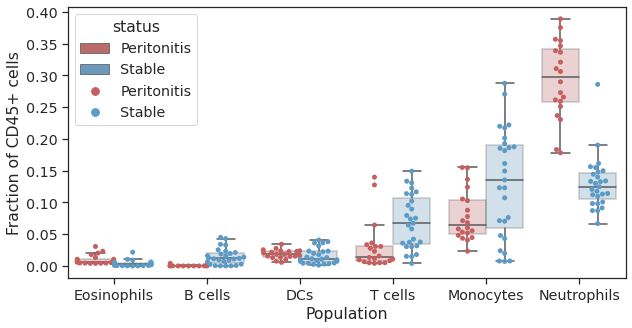

In [30]:
# XGBoost
from warnings import filterwarnings
filterwarnings("ignore")
order = ["Eosinophils", "B cells", "DCs", "T cells", "Monocytes", "Neutrophils"]
feature_selection.box_swarm_plot(leuk_subsets[leuk_subsets.Method == "XGB"],
                                 x="Population",
                                 y="Fraction of CD45+ cells",
                                 hue="status",
                                 palette=["#c75f5f", "#5d9bc7"],
                                 boxplot_kwargs={"order": order},
                                 overlay_kwargs={"order": order})
plt.savefig("figures/feature_selection/XGB_leukocytes_boxswarm.png",
            dpi=300,
            facecolor="white",
            bbox_inches="tight")

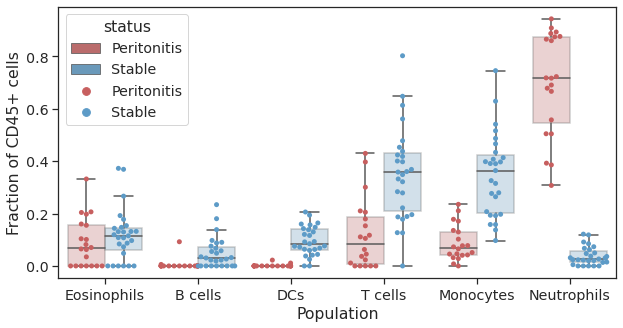

In [31]:
# FlowSOM
feature_selection.box_swarm_plot(leuk_subsets[leuk_subsets.Method == "FlowSOM"],
                                 x="Population",
                                 y="Fraction of CD45+ cells",
                                 hue="status",
                                 palette=["#c75f5f", "#5d9bc7"],
                                 boxplot_kwargs={"order": order},
                                 overlay_kwargs={"order": order})
plt.savefig("figures/feature_selection/FlowSOM_leukocytes_boxswarm.png",
            dpi=300,
            facecolor="white",
            bbox_inches="tight")

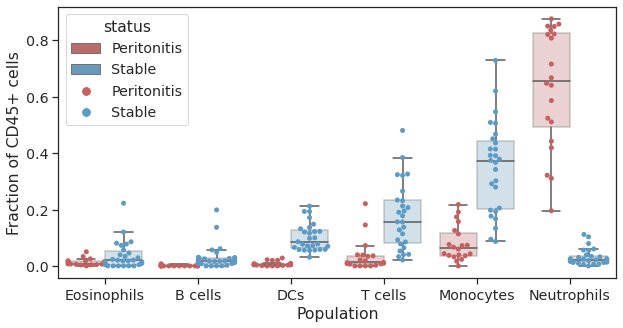

In [32]:
# Phenograph
feature_selection.box_swarm_plot(leuk_subsets[leuk_subsets.Method == "Phenograph"],
                                 x="Population",
                                 y="Fraction of CD45+ cells",
                                 hue="status",
                                 palette=["#c75f5f", "#5d9bc7"],
                                 boxplot_kwargs={"order": order},
                                 overlay_kwargs={"order": order})
plt.savefig("figures/feature_selection/Phenograph_leukocytes_boxswarm.png",
            dpi=300,
            facecolor="white",
            bbox_inches="tight")

We see similar proportions across all subsets. The main different is in DCs in peritonitis patients; the decrease in this subset is more pronounced in peritonitis patients in clustering analysis compared to XGBoost.

Additionally, the overall fraction of CD45+ cells is much higher in clustering compared to XGBoost trained on manual gates. The reasoning being that XGBoost is elimative whereas clustering is inclusive. To elaborate, the gates we generate to define populations for training data for XGBoost can be narrow and eliminate events, the result being that XGBoost designates a higher percentage of cells as "undefined". Compare this to FlowSOM and Phenograph, that do not exclude events in the clustering process, but rather group events by similar phenotype.

This is not of concern because the general pattern and ratio of cell subsets is conserved between methods.

What if we want to test if the difference between these subsets is statistically significant? For this we use the `InferenceTesting` from `feature_selection`. This takes a DataFrame in long format and allows us to perform any number of statistical inference tests provided by the <a href=https://pingouin-stats.org/guidelines.html>Pingouin</a> library.

In [33]:
leuk_subsets = feature_space[["status"] + columns]
tests = feature_selection.InferenceTesting(data=leuk_subsets)

First we want to ensure our variables support the assumption of normality so we can decide whether to perform parametric or non-parametric testing. This can be achieved with QQ plots of individual variables:

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

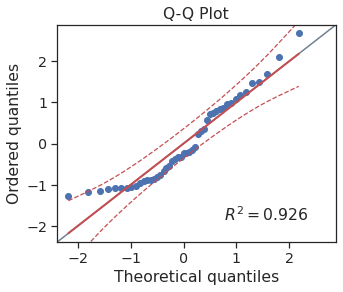

In [34]:
tests.qq_plot("Phenograph_Monocytes_FOP")

Or by calling the `normality` method, which returns a dataframe of True/False values. By default this uses the Shapiro-Wilk method with a significance level of 0.05.

In [35]:
populations = ["Monocytes_FOP",
               "Neutrophils_FOP",
               "Eosinophils_FOP",
               "DCs_FOP",
               "T cells_FOP",
               "B cells_FOP"]

In [36]:
tests.normality([f"Phenograph_{x}" for x in populations])

,Variable,Normal
0,Phenograph_Monocytes_FOP,False
1,Phenograph_Neutrophils_FOP,False
2,Phenograph_Eosinophils_FOP,False
3,Phenograph_DCs_FOP,False
4,Phenograph_T cells_FOP,False
5,Phenograph_B cells_FOP,False


Since the assumption of normality is broken, we use the `non_parametric` function to apply the appropriate test. If this wasn't the case we could use `InferenceTest`'s `anova` function (for multiple groups) or the `ttest` function. All these functions will calculate the most appropriate test to apply based on testing assumptions of equal variance (homoscedasticity) and whether the analysis is paired. 

Below we can see this applied for testing the difference between status for different populations identified by Phenograph. The result is that multiple mann-whitney U tests are performed. P-values are automatically corrected for multiple comparisons and by default this is performed using Holm's method.

In [37]:
tests.non_parametric(between="status", ind_var=[f"Phenograph_{x}" for x in populations],
                     paired=False)

,U-val,tail,p-val,RBC,CLES,Variable
MWU,24.0,two-sided,5.102355e-07,0.911111,0.044444,Phenograph_Monocytes_FOP
MWU,540.0,two-sided,3.993457e-08,-1.000000,1.000000,Phenograph_Neutrophils_FOP
MWU,197.0,two-sided,1.181742e-01,0.270370,0.364815,Phenograph_Eosinophils_FOP
MWU,0.0,two-sided,3.993457e-08,1.000000,0.000000,Phenograph_DCs_FOP
MWU,46.0,two-sided,4.520098e-06,0.829630,0.085185,Phenograph_T cells_FOP
MWU,59.0,two-sided,6.271984e-06,0.781481,0.109259,Phenograph_B cells_FOP


Below we repeat the same for the other identification techniques:

In [38]:
tests.normality([f"FlowSOM_{x}" for x in populations])

,Variable,Normal
0,FlowSOM_Monocytes_FOP,False
1,FlowSOM_Neutrophils_FOP,False
2,FlowSOM_Eosinophils_FOP,False
3,FlowSOM_DCs_FOP,False
4,FlowSOM_T cells_FOP,False
5,FlowSOM_B cells_FOP,False


In [39]:
tests.non_parametric(between="status", ind_var=[f"FlowSOM_{x}" for x in populations],
                     paired=False)

,U-val,tail,p-val,RBC,CLES,Variable
MWU,27.0,two-sided,7.243636e-07,0.900000,0.050000,FlowSOM_Monocytes_FOP
MWU,540.0,two-sided,3.930019e-08,-1.000000,1.000000,FlowSOM_Neutrophils_FOP
MWU,219.0,two-sided,2.721152e-01,0.188889,0.405556,FlowSOM_Eosinophils_FOP
MWU,22.0,two-sided,1.489027e-07,0.918519,0.040741,FlowSOM_DCs_FOP
MWU,77.5,two-sided,1.063157e-04,0.712963,0.143519,FlowSOM_T cells_FOP
MWU,113.0,two-sided,3.678553e-04,0.581481,0.209259,FlowSOM_B cells_FOP


In [40]:
tests.non_parametric(between="status", ind_var=[f"XGB_{x}" for x in populations],
                     paired=False)

,U-val,tail,p-val,RBC,CLES,Variable
MWU,175.5,two-sided,8.622542e-02,0.350000,0.325000,XGB_Monocytes_FOP
MWU,529.0,two-sided,1.599886e-07,-0.959259,0.979630,XGB_Neutrophils_FOP
MWU,462.0,two-sided,1.512704e-04,-0.711111,0.855556,XGB_Eosinophils_FOP
MWU,353.0,two-sided,8.622542e-02,-0.307407,0.653704,XGB_DCs_FOP
MWU,111.0,two-sided,1.946194e-03,0.588889,0.205556,XGB_T cells_FOP
MWU,55.0,two-sided,1.953781e-05,0.796296,0.101852,XGB_B cells_FOP


Now we do the same for the T cell subsets:

In [41]:
populations = ["CD4+ T cells_FOP",
               "CD8+ T cells_FOP",
               "Vd2+ GDTs_FOP",
               "MAIT cells_FOP"]
columns = [x for x in feature_space.columns if any([p in x for p in populations])]

In [42]:
tcell_subsets = feature_space[["status"] + columns]
tcell_subsets = tcell_subsets.melt(id_vars="status", 
                                  value_name="Fraction of T cells",
                                  var_name="pop_name")
tcell_subsets["Method"] = tcell_subsets["pop_name"].apply(lambda x: x.split("_")[0])
tcell_subsets["Population"] = tcell_subsets["pop_name"].apply(lambda x: x.split("_")[1])
tcell_subsets = tcell_subsets[["status", "Population", "Fraction of T cells", "Method"]]

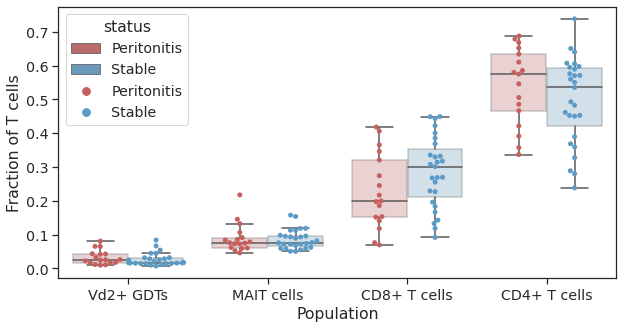

In [43]:
from warnings import filterwarnings
filterwarnings("ignore")
order = ["Vd2+ GDTs", "MAIT cells", "CD8+ T cells", "CD4+ T cells"]
feature_selection.box_swarm_plot(tcell_subsets[tcell_subsets.Method == "XGB"],
                                 x="Population",
                                 y="Fraction of T cells",
                                 hue="status",
                                 palette=["#c75f5f", "#5d9bc7"],
                                 boxplot_kwargs={"order": order},
                                 overlay_kwargs={"order": order})
plt.savefig("figures/feature_selection/XGB_tcells_boxswarm.png",
            dpi=300,
            facecolor="white",
            bbox_inches="tight")

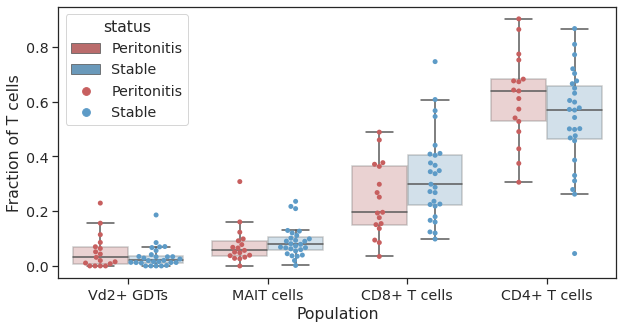

In [44]:
feature_selection.box_swarm_plot(tcell_subsets[tcell_subsets.Method == "FlowSOM"],
                                 x="Population",
                                 y="Fraction of T cells",
                                 hue="status",
                                 palette=["#c75f5f", "#5d9bc7"],
                                 boxplot_kwargs={"order": order},
                                 overlay_kwargs={"order": order})
plt.savefig("figures/feature_selection/FlowSOM_tcells_boxswarm.png",
            dpi=300,
            facecolor="white",
            bbox_inches="tight")

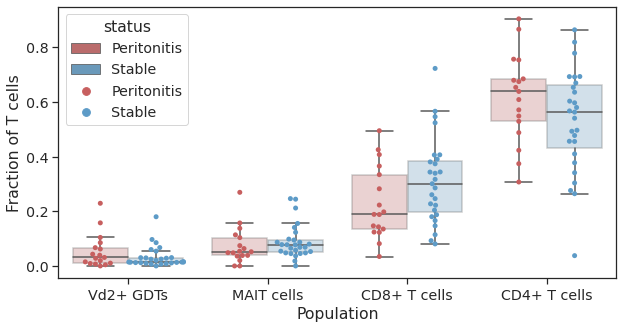

In [45]:
feature_selection.box_swarm_plot(tcell_subsets[tcell_subsets.Method == "Phenograph"],
                                 x="Population",
                                 y="Fraction of T cells",
                                 hue="status",
                                 palette=["#c75f5f", "#5d9bc7"],
                                 boxplot_kwargs={"order": order},
                                 overlay_kwargs={"order": order})
plt.savefig("figures/feature_selection/Phenograph_tcells_boxswarm.png",
            dpi=300,
            facecolor="white",
            bbox_inches="tight")

In [46]:
tcell_subsets = feature_space[["status"] + columns]
tests = feature_selection.InferenceTesting(data=tcell_subsets)

In [47]:
populations = ["CD4+ T cells_FOP",
               "CD8+ T cells_FOP",
               "Vd2+ GDTs_FOP",
               "MAIT cells_FOP"]

In [48]:
tests.normality([f"Phenograph_{x}" for x in populations])

,Variable,Normal
0,Phenograph_CD4+ T cells_FOP,True
1,Phenograph_CD8+ T cells_FOP,True
2,Phenograph_Vd2+ GDTs_FOP,False
3,Phenograph_MAIT cells_FOP,False


In [49]:
tests.non_parametric(between="status", ind_var=[f"Phenograph_{x}" for x in populations],
                     paired=False)

,U-val,tail,p-val,RBC,CLES,Variable
MWU,287.0,two-sided,0.508425,-0.250545,0.625272,Phenograph_CD4+ T cells_FOP
MWU,160.0,two-sided,0.385143,0.302832,0.348584,Phenograph_CD8+ T cells_FOP
MWU,269.5,two-sided,0.508425,-0.174292,0.587146,Phenograph_Vd2+ GDTs_FOP
MWU,178.0,two-sided,0.508425,0.224401,0.387800,Phenograph_MAIT cells_FOP


In [50]:
tests.normality([f"FlowSOM_{x}" for x in populations])

,Variable,Normal
0,FlowSOM_CD4+ T cells_FOP,True
1,FlowSOM_CD8+ T cells_FOP,True
2,FlowSOM_Vd2+ GDTs_FOP,False
3,FlowSOM_MAIT cells_FOP,False


In [51]:
tests.non_parametric(between="status", ind_var=[f"FlowSOM_{x}" for x in populations],
                     paired=False)

,U-val,tail,p-val,RBC,CLES,Variable
MWU,285.0,two-sided,0.554831,-0.241830,0.620915,FlowSOM_CD4+ T cells_FOP
MWU,160.0,two-sided,0.385143,0.302832,0.348584,FlowSOM_CD8+ T cells_FOP
MWU,251.0,two-sided,0.611655,-0.093682,0.546841,FlowSOM_Vd2+ GDTs_FOP
MWU,174.0,two-sided,0.554831,0.241830,0.379085,FlowSOM_MAIT cells_FOP


In [52]:
tests.non_parametric(between="status", ind_var=[f"XGB_{x}" for x in populations],
                     paired=False)

,U-val,tail,p-val,RBC,CLES,Variable
MWU,280.0,two-sided,0.684414,-0.220044,0.610022,XGB_CD4+ T cells_FOP
MWU,164.0,two-sided,0.468721,0.285403,0.357298,XGB_CD8+ T cells_FOP
MWU,276.5,two-sided,0.684414,-0.204793,0.602397,XGB_Vd2+ GDTs_FOP
MWU,223.0,two-sided,0.885011,0.028322,0.485839,XGB_MAIT cells_FOP


For the FlowSOM and Phenograph detection of T cell subsets, we have additional subsets of CD4 T cells based on memory markers of CD45RA, CCR7 and CD27. It would be interesting to see if any difference occurs between these groups. We'll look at Phenograph since this provides more granular clustering that FlowSOM. We've written a function below that will pull out these subsets and generate a box and swarm plot like above and test for statistical significance.

In [53]:
def subset_columns(feature_space: pd.DataFrame,
                   method: str, 
                   subset: str):
    """Return the names of columns in feature_space that are of the subset and method 
    of interest"""
    return [x for x in feature_space.columns 
            if re.search(f"{method}_{subset}\+ T cells \([0-9]+\)_N", x) 
            is not None]

def t_subsets(feature_space: pd.DataFrame,
              method: str,
              subset: str,
              figsize: tuple = (10, 5)):
    subset_df = feature_space[["status"]]
    for x in subset_columns(feature_space, method, subset):
        subset_df[f"{x.split('_')[1]}"] = feature_space[x]/feature_space[f"{method}_{subset}+ T cells_N"]
    tests = feature_selection.InferenceTesting(data=subset_df)
    stats = tests.non_parametric(between="status", ind_var=[x for x in subset_df if x != "status"],
                                 paired=False)
    subset_df = subset_df.melt(id_vars="status",
                             value_name=f"Fraction of {subset}+ T cells",
                             var_name="Population")

    fig, ax = plt.subplots(figsize=figsize)
    feature_selection.box_swarm_plot(subset_df,
                                     x="Population",
                                     y=f"Fraction of {subset}+ T cells",
                                     hue="status",
                                     palette=["#c75f5f", "#5d9bc7"],
                                     ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1.02, 1))
    ax.set_xlabel("")
    plt.show()
    return stats

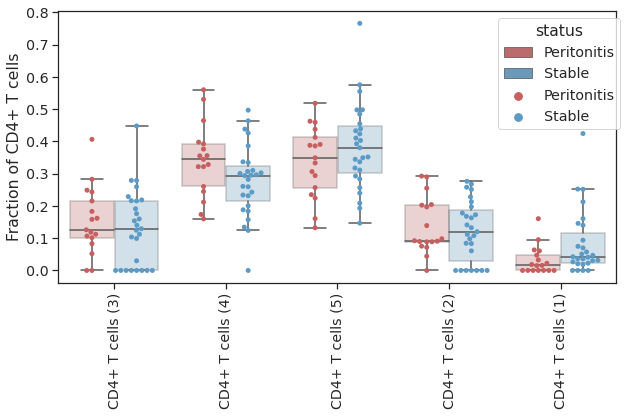

,U-val,tail,p-val,RBC,CLES,Variable
MWU,252.0,two-sided,1.000000,-0.098039,0.549020,CD4+ T cells (3)
MWU,310.0,two-sided,0.215286,-0.350763,0.675381,CD4+ T cells (4)
MWU,190.0,two-sided,1.000000,0.172113,0.413943,CD4+ T cells (5)
MWU,242.5,two-sided,1.000000,-0.056645,0.528322,CD4+ T cells (2)
MWU,133.0,two-sided,0.098484,0.420479,0.289760,CD4+ T cells (1)


In [54]:
t_subsets(feature_space, "Phenograph", "CD4")

There might be a slight different in CD4$^{+}$ T cells of subset 1 (if you consult our clustering analysis notebook you can see these are naive CD4 T cells that are CD45RA, CCR7 and CD27 positive).

We can take a further look by generating a new `FeatureSpace` and obtaining the median flourescent intensity for these three markers for our CD4+ population as obtained by XGBoost classification. We didn't tell XGBoost to further subset CD4 populations but by looking at the median flourescent intensity we might observe a difference in these channels between stable controls and peritonitis patients.

In [55]:
feature_space_tcells = feature_selection.FeatureSpace(experiment=tcells, 
                                                      sample_ids=samples)
feature_space_tcells =(feature_space_tcells
                         .channel_desc_stats(channel="CD45RA",
                                             stats=["median"],
                                             channel_transform="logicle",
                                             populations=["XGB_CD4+ T cells"])
                         .channel_desc_stats(channel="CCR7",
                                             stats=["median"],
                                             channel_transform="logicle",
                                             populations=["XGB_CD4+ T cells"])
                         .channel_desc_stats(channel="CD27",
                                             stats=["median"],
                                             channel_transform="logicle",
                                             populations=["XGB_CD4+ T cells"])
                         .add_meta_labels("status")
                         .add_meta_labels("age")
                         .add_meta_labels("gender")
                         .construct_dataframe())

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Let's generate a heatmap for these three memory markers for CD4+ T cells, with each row being a different subject and each column being one of the three markers. We will colour the rows by the patient statis:

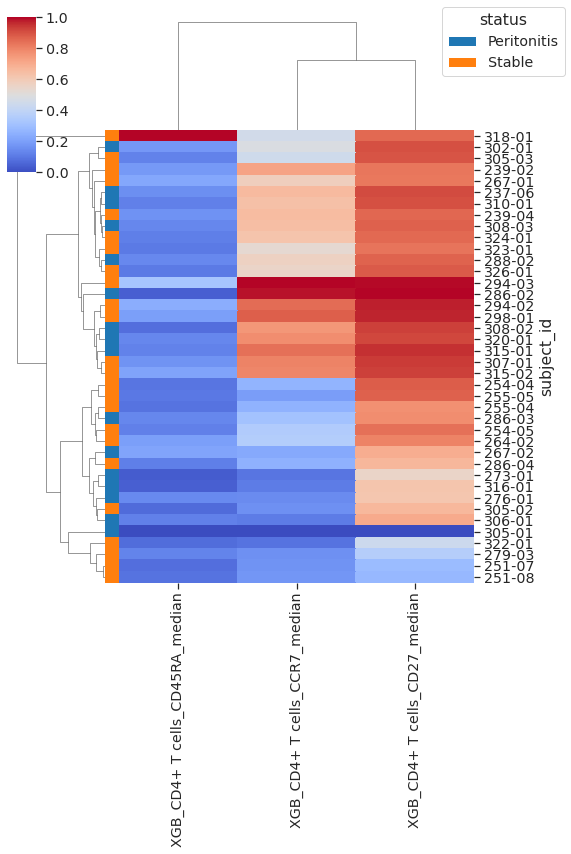

In [56]:
x = feature_space_tcells[["status",
                          "subject_id",
                          "XGB_CD4+ T cells_CD45RA_median",
                          "XGB_CD4+ T cells_CCR7_median",
                          "XGB_CD4+ T cells_CD27_median"]]
feature_selection.clustered_heatmap(x,
                                    features=["XGB_CD4+ T cells_CD45RA_median",
                                              "XGB_CD4+ T cells_CCR7_median",
                                              "XGB_CD4+ T cells_CD27_median"],
                                    index="subject_id",
                                    cmap="coolwarm",
                                    standard_scale=1,
                                    row_colours="status",
                                    figsize=(8, 12),
                                    yticklabels=True,
                                    row_colours_cmap=plt.get_cmap("tab10").colors)

There is no clear grouping of peritonitis patients in the above heatmap.

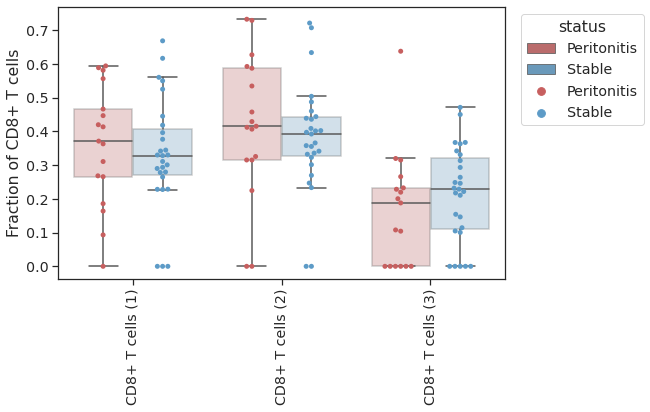

,U-val,tail,p-val,RBC,CLES,Variable
MWU,256.5,two-sided,0.797433,-0.117647,0.558824,CD8+ T cells (1)
MWU,265.0,two-sided,0.797433,-0.154684,0.577342,CD8+ T cells (2)
MWU,173.0,two-sided,0.521133,0.246187,0.376906,CD8+ T cells (3)


In [57]:
t_subsets(feature_space, "Phenograph", "CD8", figsize=(8, 5))

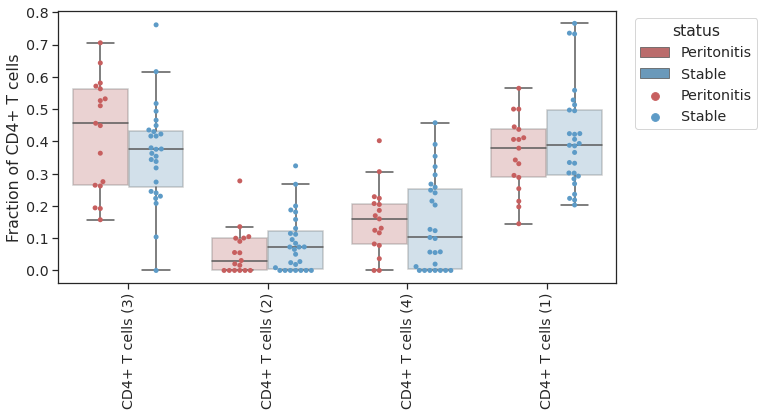

,U-val,tail,p-val,RBC,CLES,Variable
MWU,285.0,two-sided,0.739775,-0.241830,0.620915,CD4+ T cells (3)
MWU,191.0,two-sided,1.000000,0.167756,0.416122,CD4+ T cells (2)
MWU,252.0,two-sided,1.000000,-0.098039,0.549020,CD4+ T cells (4)
MWU,200.0,two-sided,1.000000,0.128540,0.435730,CD4+ T cells (1)


In [58]:
t_subsets(feature_space, "FlowSOM", "CD4")

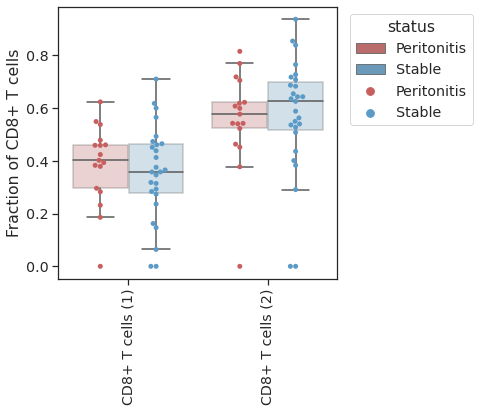

,U-val,tail,p-val,RBC,CLES,Variable
MWU,259.0,two-sided,0.968983,-0.128540,0.56427,CD8+ T cells (1)
MWU,207.0,two-sided,0.968983,0.098039,0.45098,CD8+ T cells (2)


In [59]:
t_subsets(feature_space, "FlowSOM", "CD8", figsize=(5, 5))

<h2>Removing redundant variables</h2>

Above we have performed univariant analysis, which has given a clear indication that the fraction of neutrophils and monocytes is indicative of acute peritonitis. But to confirm this and also demonstate CytoPy's ability to identify predictive signatures, let's perform some modeling and inspection to see the predictive value of each feature in a multivariant model.

First, because we only have 51 patient samples and an excess of features, we want to reduce the number of variables to reduce the chance that our models overfit. For this exercise, we're going to just look at the number of events for each population as a fraction of the total number of events. Since we also have good consensus between our three methods, we're going to take an average of the three for each population. We'll also not include CD4 and CD8 subsets, since there was little value shown in the univariant analysis. Additionally, we'll include and and gender as possible confounding variables.

In [12]:
for_columns = [x for x in feature_space.columns if "FOR" in x and "root" not in x]

In [13]:
populations_to_avg = ["Neutrophils_FOR",
                      "Eosinophils_FOR",
                      "_T cells_FOR",
                      "DCs_FOR",
                      "Monocytes_FOR",
                      "B cells_FOR",
                      "_CD4+ T cells_FOR",
                      "_CD8+ T cells_FOR",
                      "Vd2+ GDTs_FOR",
                      "MAIT cells_FOR"]
for p in populations_to_avg:
    x = [x for x in feature_space.columns if p in x]
    feature_space[p] = feature_space[x].mean(axis=1)
feature_space.columns = [x.replace("_FOR", "").replace("_", "")
                                 for x in feature_space.columns]

In [14]:
features = ['Neutrophils', 'Eosinophils', 'T cells', 'DCs', 'Monocytes',
            'B cells', 'CD4+ T cells', 'CD8+ T cells', 'Vd2+ GDTs', 
            'MAIT cells']
feature_space = feature_space[["status", "age", "Female"] + features]

In [15]:
feature_space.rename({"age": "Age"}, axis=1, inplace=True)

In [17]:
features = ['Neutrophils', 'Eosinophils', 'T cells', 'DCs', 'Monocytes',
            'B cells', 'CD4+ T cells', 'CD8+ T cells', 'Vd2+ GDTs', 
            'MAIT cells', "Age", "Female"]

<h3>Multi-colinearity and replicated variables</h3>

We're going to be mostly relying on simple linear models and therefore multicolinearity will influence the coefficients of the features we inspect, which can lead to misinterpretation of our results. We therefore want to reduce multicolinearity as much as possible such that our variables are more or less independent; of course, this assumption of independence can never be 100% assured in biology, but we have access to non-linear modelling as well.

Below we demonstate the `plot_multicolinearity` function, which by default plots the spearman rank correlation coefficient for each pair of features.

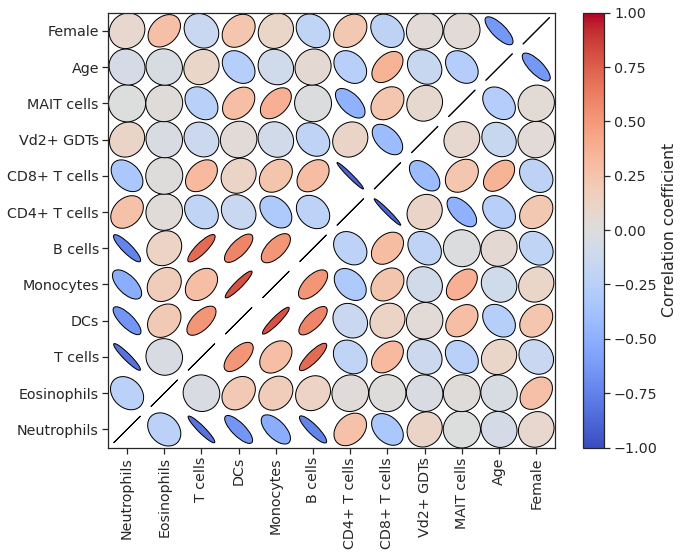

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
ax, m = feature_selection.plot_multicolinearity(data=feature_space,
                                            features=features,
                                            cmap="coolwarm",
                                            edgecolor="black",
                                             ax=ax,
                                            clim=[-1, 1])
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')
ax.margins(0.1)
plt.savefig("figures/feature_selection/multicol.png",
            dpi=300,
            facecolor="white",
            bbox_inches="tight")

From this it is clear that we want to drop DCs, B cells, and CD8+ T cells to avoid issues of collinearity, and we know that these subsets have a low variance from our univariant analysis.

In [18]:
feature_space.drop(["DCs", "B cells", "CD8+ T cells"],
                   axis=1, inplace=True)

<h2>PCA</h2>

A quick and simple way to observing if our patient groups are separable is performing principle component analysis, a dimension reduction technique that resolves the linear combination of our features to a lower embedded space. A PCA can also provide some insight into the importance of particular features since the coefficients of each component speak to the contribution of a feature to the explained variance of a component.

We can use CytoPy's `PCA` class that makes generating our PCA simply and provides useful utility and plotting methods.

In [20]:
pca = feature_selection.PCA(data=feature_space,
                            features=[x for x in feature_space.columns
                                      if x != "status"])

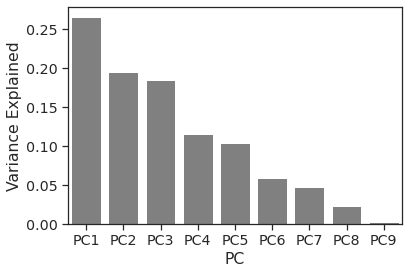

In [21]:
pca.fit()
pca.scree_plot(color="grey")
plt.savefig("figures/feature_selection/pca_var.png",
            dpi=300,
            facecolor="white",
            bbox_inches="tight")

In [70]:
pca.loadings()

,Feature,EV Magnitude
0,Age,0.354608
1,Female,0.315145
2,Neutrophils,0.513767
3,Eosinophils,0.028397
4,T cells,0.371938
5,Monocytes,0.387702
6,CD4+ T cells,0.449070
7,Vd2+ GDTs,0.064394
8,MAIT cells,0.125351


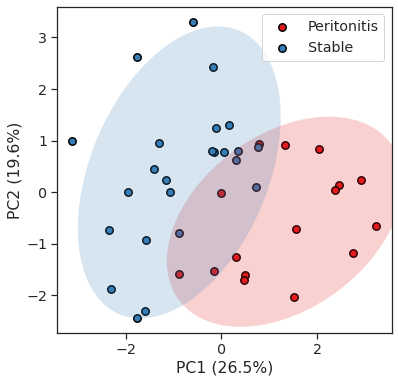

In [71]:
fig, ax = pca.plot(label="status", 
                   components=[0, 1],
                   size=55,
                   linewidth=1.5,
                   edgecolor="black",
                   cmap="Set1",
                   ellipse=True,
                   figsize=(6, 6),
                   ellipse_kwargs={"s": 2,
                                   "linewidth": 0})
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel(f"PC1 ({round(pca.pca.explained_variance_ratio_[0]* 100, 1)}%)")
ax.set_ylabel(f"PC2 ({round(pca.pca.explained_variance_ratio_[1]* 100, 1)}%)")
plt.savefig("figures/feature_selection/pca.png",
            dpi=300,
            facecolor="white",
            bbox_inches="tight")

Our patient groups are separated along the first component, for which the coefficient for Neutrophils is the greatest.

<h2>L1 Selection</h2>

A method for eliminating redundant variables is to apply an L1 regularisation penalty to linear models; in linear regression this is referred to as 'lasso' regression. The l1 norm of the weight vector is added to the cost function and results in the weights of less important features (i.e. those with small coefficients that do not contribute as much to predictions) being eliminated; it produces a sparse model that only includes the features that matter most.

We have to specify what type of model to use:

If performing classification (i.e. target is discrete), this can be:
* 'log' - Logistic regression (sklearn.linear_model.LogisticRegression) with set parameters penalty='l1' and solver='liblinear'
* SGD - stochastic gradient descent (sklearn.linear_model.SGDClassifier) with L1 penalty. Defaults to linear support vector machine ('hinge' loss function) but can be controlled by changing the loss parameter (https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
* SVM - linear support vector machine (sklearn.svm.LinearSVC) with set parameters penalty = 'l1',loss = 'squared_hinge' and dual = False.

If performing regression (i.e. target is continuous):
* lasso - lasso regression (sklear.linear_model.Lasso)
* stochastic gradient descent (sklearn.linear_model.SGDClassifier) with L1 penalty. Defaults to ordinary least squares ('squared_loss' loss function) but can be controlledby changing the loss parameter (https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)
* SVM - linear support vector machine (sklearn.svm.LinearSVR) with set parameter loss="epsilon_insensitive"

Here we're going to use a support vector machine with a linear kernel. We also specify the scale the data prior to fitting the model.

In [72]:
features = ['Neutrophils', 'Eosinophils', 'T cells', 'Monocytes',
            'CD4+ T cells', 'Vd2+ GDTs', 'MAIT cells', "Age", "Female"]
l1 = feature_selection.L1Selection(data=feature_space,
                                  target="status",
                                  features=features,
                                  model="SVM",
                                  category="classification",
                                  scale="standard")

In [73]:
l1 = l1.fit()

By varying the regularisation parameter and observing the coefficient of each of our features, we can see how each contributes to the predictive performance of our model. We can see clearly below that Neutrophils are the most important variable when comparing acute peritonitis patients with stable controls. Monocytes are second to this, but we must remember that they're correlated with the number of Neutrophils present.

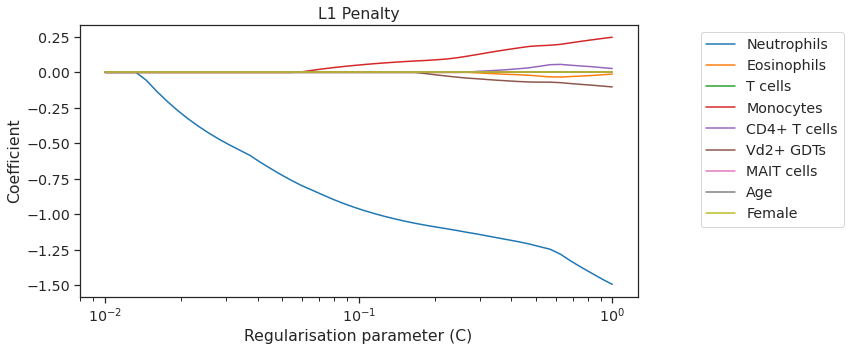

In [74]:
ax = l1.plot(xlabel="Regularisation parameter (C)")
plt.savefig("figures/feature_selection/l1_selection.png",
            dpi=300,
            facecolor="white",
            bbox_inches="tight")

<h2>Decision tree</h2>

Decision tree's offer non-linear modelling for both regression and classification tasks, whilst also being simple to interpret and offers information regarding feature interactions. Their simplicity comes with a trade-off as they are prone to overfitting and can therefore be misinterpreted. Therefore the DecisionTree class offers validation methods and pruning to improve the reliability of results. Despite this, we recommend that care be taking when constructing decision trees and that the number of features limited.

In [21]:
features = ['Neutrophils', 'Eosinophils', 'T cells', 'Monocytes',
            'CD4+ T cells', 'Vd2+ GDTs', 'MAIT cells', "Age", "Female"]
decision_tree = feature_selection.DecisionTree(data=feature_space,
                                               target="status",
                                               features=features,
                                               tree_type="classification",
                                               balance_classes="sample")

In [22]:
decision_tree.validate_tree(validation_frac=0.7)

,accuracy_score,Dataset
0,1.000000,Training
1,0.852941,Testing


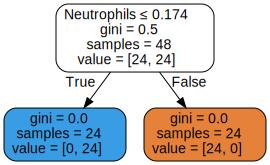

In [23]:
decision_tree.plot_tree()

Below we see that the desicion tree ends abruptly, with the seperation of stable and peritonitis patients made possible with the neutrophil variable alone, this is clarrified by the boxplot below:

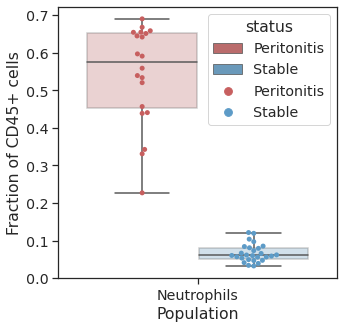

In [26]:
cell_features = ['Neutrophils']
x = feature_space[["status"] + cell_features]
x = x.melt(id_vars="status",
           var_name="Population",
           value_name="Fraction of CD45+ cells")
fig, ax = plt.subplots(figsize=(5, 5))
feature_selection.box_swarm_plot(x,
                                 x="Population",
                                 y="Fraction of CD45+ cells",
                                 hue="status",
                                 ax=ax,
                                 palette=["#c75f5f", "#5d9bc7"])
plt.savefig("figures/feature_selection/neutro_avg_fraction.png",
            dpi=300,
            facecolor="white",
            bbox_inches="tight")

<AxesSubplot:xlabel='Population', ylabel='Fraction of T cells'>

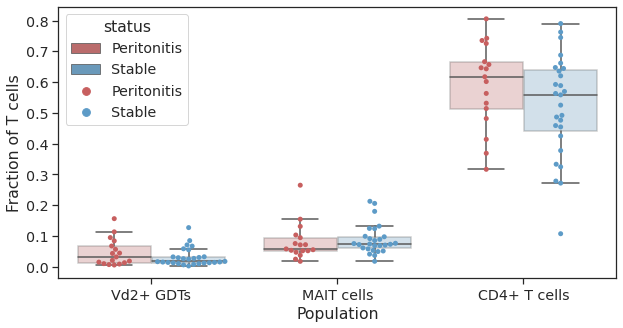

In [79]:
cell_features = ['CD4+ T cells', 'Vd2+ GDTs', 'MAIT cells']
x = feature_space[["status"] + cell_features]
x = x.melt(id_vars="status",
           var_name="Population",
           value_name="Fraction of T cells")
order = ['Vd2+ GDTs', 'MAIT cells', 'CD4+ T cells']
kwargs = dict(order=order)
feature_selection.box_swarm_plot(x,
                                 x="Population",
                                 y="Fraction of T cells",
                                 hue="status",
                                 palette=["#c75f5f", "#5d9bc7"],
                                 boxplot_kwargs=kwargs,
                                 overlay_kwargs=kwargs)

<h2>L1 Selection (drop Neutrophils)</h2>

In [80]:
features = ['Eosinophils', 'T cells', 'Monocytes',
            'CD4+ T cells', 'Vd2+ GDTs', 'MAIT cells', "Age", "Female"]
l1 = feature_selection.L1Selection(data=feature_space,
                                  target="status",
                                  features=features,
                                  model="SVM",
                                  category="classification",
                                  scale="standard")

In [81]:
l1 = l1.fit()

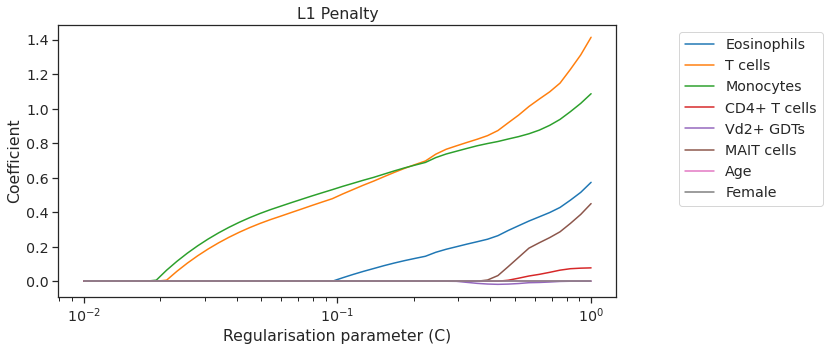

In [82]:
ax = l1.plot(xlabel="Regularisation parameter (C)")

<h2>Decision tree (drop Neutrophils)</h2>

In [83]:
decision_tree = feature_selection.DecisionTree(data=feature_space,
                                               target="status",
                                               features=features,
                                               tree_type="classification",
                                               balance_classes="sample")

In [84]:
decision_tree.validate_tree(validation_frac=0.7)

,accuracy_score,Dataset
0,1.000000,Training
1,0.764706,Testing


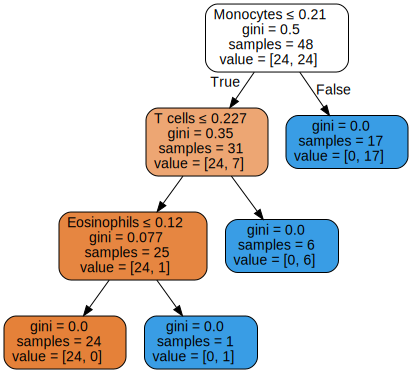

In [85]:
decision_tree.plot_tree()

<h1>Infection source</h1>

We also seeked to investigate the underlying source of infection by as shown here, there is a massive class imbalance and numerous patients with unknown source of infection. This makes drawing any meaningful conclusion difficult.

In [86]:
project = Project.objects(project_id="Immunofingerprints").get()
tcells = project.load_experiment("Corrected drain fluid T cells")
leukocytes = project.load_experiment("Corrected drain fluid Leukocytes")

In [87]:
samples = [x for x in tcells.list_samples() if x != "Training Data"]
feature_space_tcells = feature_selection.FeatureSpace(experiment=tcells, sample_ids=samples)

In [88]:
feature_space_tcells.add_meta_labels("status")
feature_space_tcells.add_meta_labels("age")
feature_space_tcells.add_meta_labels("gender")
feature_space_tcells.add_meta_labels(["infection_data", "gram_status"], "Infection class")
feature_space_tcells = feature_space_tcells.construct_dataframe()

In [89]:
samples = [x for x in leukocytes.list_samples() if x != "Training Data"]
feature_space_leukocytes = feature_selection.FeatureSpace(experiment=leukocytes, 
                                                          sample_ids=samples)

In [90]:
feature_space_leukocytes.add_meta_labels("status")
feature_space_leukocytes.add_meta_labels("age")
feature_space_leukocytes.add_meta_labels("gender")
feature_space_leukocytes.add_meta_labels(["infection_data", "gram_status"], "Infection class")
feature_space_leukocytes = feature_space_leukocytes.construct_dataframe()

In [91]:
keys = ["subject_id", "status", "age", "gender", "Infection class"]
feature_space = feature_space_leukocytes.merge(feature_space_tcells, on=keys, how="outer")
feature_space.drop(["sample_id_x", "sample_id_y"], axis=1, inplace=True)

In [92]:
feature_space = feature_space[feature_space.status == "Peritonitis"]

In [93]:
feature_space["Infection class"].value_counts()

Positive    13
Unknown      5
Negative     1
Other        1
Mixed        1
Name: Infection class, dtype: int64